In [2]:
# Cohort + Retention Analysis with Online Retail Dataset

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from datetime import datetime

In [3]:
# Load and clean data
df = pd.read_csv("../data/cleaned_data/online_retail_df.csv")
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396340 entries, 0 to 396339
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    396340 non-null  int64         
 1   StockCode    396340 non-null  object        
 2   Description  396340 non-null  object        
 3   Quantity     396340 non-null  int64         
 4   InvoiceDate  396340 non-null  datetime64[ns]
 5   UnitPrice    396340 non-null  float64       
 6   CustomerID   396340 non-null  float64       
 7   Country      396340 non-null  object        
 8   TotalPrice   396340 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 27.2+ MB


In [5]:

# Cohort features
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

def get_month_diff(d1, d2):
    return (d2.year - d1.year) * 12 + (d2.month - d1.month)

df['CohortIndex'] = df.apply(
    lambda row: get_month_diff(row['CohortMonth'].to_timestamp(), row['InvoiceMonth'].to_timestamp()), axis=1)

In [6]:
# Cohort counts
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_sizes = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_sizes, axis=0)

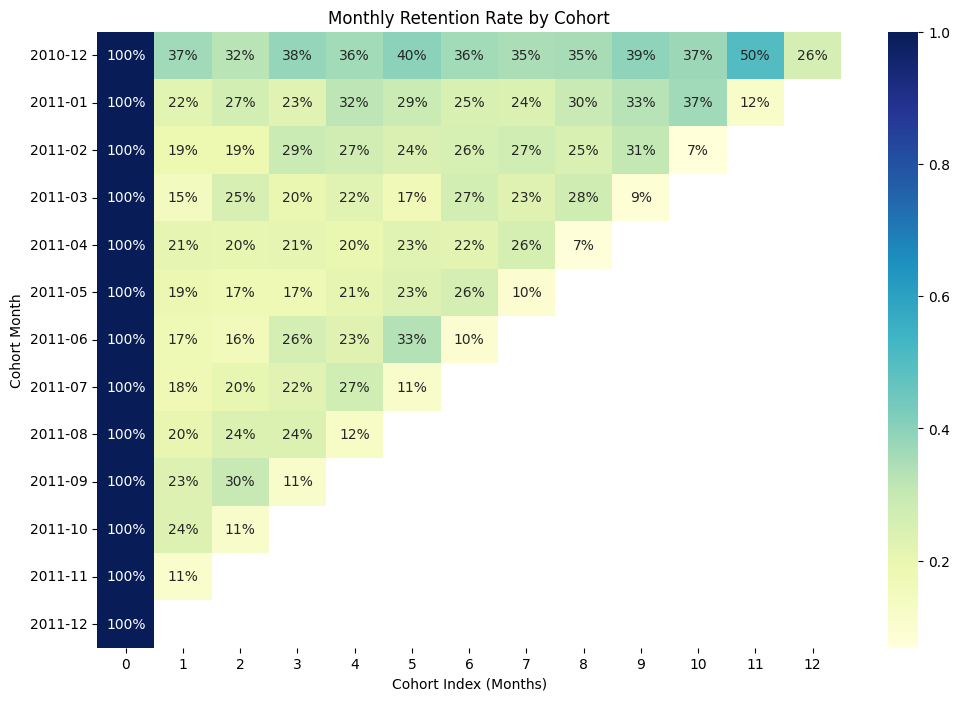

In [7]:
# Retention heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu')
plt.title('Monthly Retention Rate by Cohort')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Cohort Month')
plt.show()

Great question. Here's how to interpret the **Cohort Retention Heatmap** from a business perspective:

---

### 🔍 What the Chart Shows:

* **Rows** = Customer cohorts, defined by the **first month** they made a purchase (e.g., `2010-12`, `2011-01`, etc.).
* **Columns** = Number of months since their first purchase (`Cohort Index` 0 to 12).
* **Values** = % of the original cohort that returned to make a purchase that month.

---

### 📈 Key Business Insights:

#### 1. **Strong First Month Acquisition**

* All cohorts have `100%` in month `0`, which just confirms all customers in that cohort purchased in that month (by definition).

#### 2. **Drop in Retention After Month 0**

* For almost all cohorts, there's a **sharp drop after month 0**.
* For example: the `2011-01` cohort drops from `100%` to `22%` in month 1.
* **Business Implication:** Customers are not being engaged effectively after their first purchase. There's a retention gap.

#### 3. **Best Performing Cohorts**

* Cohort `2010-12` stands out — it retains **\~36-50%** of its customers across several months.
* **Possible reasons**: better offers, seasonality (December = holidays), or more loyal segment acquired.

#### 4. **Worst Performing Cohorts**

* Recent cohorts (e.g. `2011-09` to `2011-12`) have very **low retention** after month 1 or 2.
* **Implication:** Marketing or product strategies may have changed for the worse, or seasonal customers were acquired.

#### 5. **Churn Behavior**

* Most cohorts reach near-zero retention by month 6–9.
* **This shows high churn** — which may mean:

  * Customers don’t see long-term value
  * Lack of subscription/loyalty programs
  * One-off purchases dominate

---

### 📊 Business Actions to Consider:

| Insight                            | Action                                                                           |
| ---------------------------------- | -------------------------------------------------------------------------------- |
| Low retention after first purchase | Implement onboarding email series, discounts on second purchase, loyalty rewards |
| Strong holiday cohort (2010-12)    | Analyze what worked then — repeat successful campaigns                           |
| High churn by 3–6 months           | Introduce reactivation campaigns before months 2–3                               |
| Certain months worse than others   | Align this with marketing spend, acquisition channel, and customer type          |

---

### 🧠 Summary Statement You Can Use:

> "Our cohort retention analysis shows a significant drop in customer engagement after the first month, with most customers churning by month 3. However, certain cohorts like Dec 2010 show stronger long-term retention, indicating that specific periods or campaigns may be more effective. This highlights the need to improve post-purchase engagement and build loyalty pathways early in the customer lifecycle."

Let me know if you’d like to overlay **revenue retention**, **channel-wise cohorts**, or create a dashboard version for presentation!


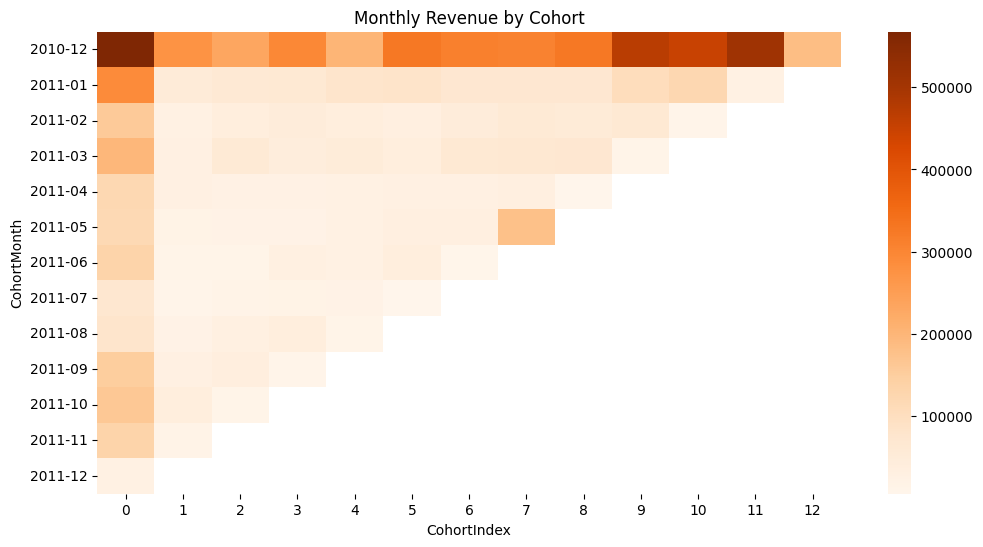

In [8]:
# Revenue by cohort
revenue_data = df.groupby(['CohortMonth', 'CohortIndex'])['TotalPrice'].sum().reset_index()
revenue_pivot = revenue_data.pivot(index='CohortMonth', columns='CohortIndex', values='TotalPrice')

plt.figure(figsize=(12, 6))
sns.heatmap(revenue_pivot, fmt='.0f', cmap='Oranges')
plt.title('Monthly Revenue by Cohort')
plt.show()

This **Monthly Revenue by Cohort** heatmap complements the retention heatmap beautifully. Here's the detailed business interpretation:

---

### 🔍 What It Shows:

* **Rows** = Customer cohorts (grouped by their first purchase month).
* **Columns** = Number of months since first purchase (cohort index).
* **Cell values** = Revenue generated by that cohort in that month.
* **Color intensity** = Higher revenue = darker color.

---

### 🧠 Business Interpretation:

#### 1. **Cohort 2010-12 is Outstanding**

* Generates **strong revenue repeatedly** across 12 months.
* Unlike other cohorts, it shows **sustained monetization**, not just initial.
* **Possible reasons:**

  * Strong seasonal sales (Christmas)
  * High-value acquisition
  * Product-market fit or effective campaigns

#### 2. **Fast Revenue Decay in Later Cohorts**

* Cohorts from `2011-06` onward show a **sharp drop in revenue** after month 1 or 2.
* Indicates either:

  * **Lower retention** (confirmed by the earlier chart)
  * OR **lower spending per customer**

#### 3. **Revenue Does Not Always Follow Retention**

* Some months (like `2011-04`, index 6) show **random revenue spikes** despite lower retention.
* This could be from:

  * A single high-value purchase
  * Bulk corporate orders
  * Promotional campaigns

#### 4. **Low LTV Cohorts**

* Cohorts like `2011-08`, `2011-09`, etc. show weak activity after month 0.
* **Likely one-time buyers**, contributing very little long-term revenue.
* This indicates **low Customer Lifetime Value (CLV)** and poor repeat engagement.

---

### 📊 Business Actions Based on This:

| Observation                    | Business Implication                      | Suggested Action                                             |
| ------------------------------ | ----------------------------------------- | ------------------------------------------------------------ |
| 2010-12 cohort performs best   | Great acquisition/engagement at that time | Study and replicate strategy used then                       |
| Later cohorts fall off quickly | Poor retention or monetization            | Improve onboarding, engagement, and post-purchase follow-up  |
| Revenue spikes in some months  | Promotions/seasonality effect             | Plan recurring campaigns around those                        |
| Most cohorts decay sharply     | Low long-term value                       | Introduce loyalty programs, auto-replenish, or subscriptions |

---

### 🧠 Summary Insight:

> “Revenue cohort analysis reveals that while initial acquisition is successful, most cohorts fail to generate long-term revenue — except for the Dec 2010 cohort which consistently outperforms. There’s an urgent need to boost retention and monetization post-acquisition, especially for newer cohorts.”

---

Let me know if you'd like:

* 🔄 Normalized revenue per user (revenue / active customers)
* 📈 Cumulative revenue plots by cohort
* 💰 Revenue per order/customer per cohort

These add deeper value for dashboards or stakeholder presentations.


In [15]:
# normalised revenue per user (revneue / active users)

# Step 1: Calculate total revenue by cohort and cohort index
cohort_revenue = cohort_data.pivot_table(
    index='CohortMonth',
    columns='CohortIndex',
    values='TotalPrice',
    aggfunc='sum'
)

# Step 2: Calculate number of active users per cohort per month
cohort_users = cohort_data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().unstack()

# Step 3: Calculate normalized revenue per user
revenue_per_user = cohort_revenue / cohort_users

# Step 4: Plot
plt.figure(figsize=(14, 8))
sns.heatmap(revenue_per_user, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Average Revenue per Active User by Cohort')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Cohort Month')
plt.show()



KeyError: 'TotalPrice'

In [ ]:
# cumalative revenue per cohort
# Step 1: Get revenue per cohort and index
cohort_cumrev = cohort_revenue.cumsum(axis=1)

# Step 2: Plot
plt.figure(figsize=(14, 8))
for cohort in cohort_cumrev.index:
    plt.plot(cohort_cumrev.columns, cohort_cumrev.loc[cohort], label=str(cohort))

plt.title('Cumulative Revenue by Cohort Over Time')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Cumulative Revenue')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
# distribution of revneue per user 
# # Step 1: Calculate revenue per user per cohort-month
rev_per_user_detail = cohort_data.groupby(['CohortMonth', 'CustomerID'])['Revenue'].sum().reset_index()

# Step 2: Plot boxplots for each cohort
plt.figure(figsize=(14, 8))
sns.boxplot(data=rev_per_user_detail, x='CohortMonth', y='Revenue')
plt.xticks(rotation=45)
plt.title('Distribution of Total Revenue per Customer by Cohort')
plt.xlabel('Cohort Month')
plt.ylabel('Revenue per Customer')
plt.tight_layout()
plt.show()


KeyError: 'Column not found: Revenue'

 Interpretation Notes:
Plot 1 (Revenue per User): If some cohorts maintain high average spend per user in later months, they may be good candidates for loyalty programs or upsell campaigns.

Plot 2 (Cumulative Revenue): Shows customer lifetime value trajectory per cohort. Long tails imply higher long-term value.

Plot 3 (Boxplot): Identifies variability within cohorts — large spread implies some customers are generating disproportionately higher revenue.
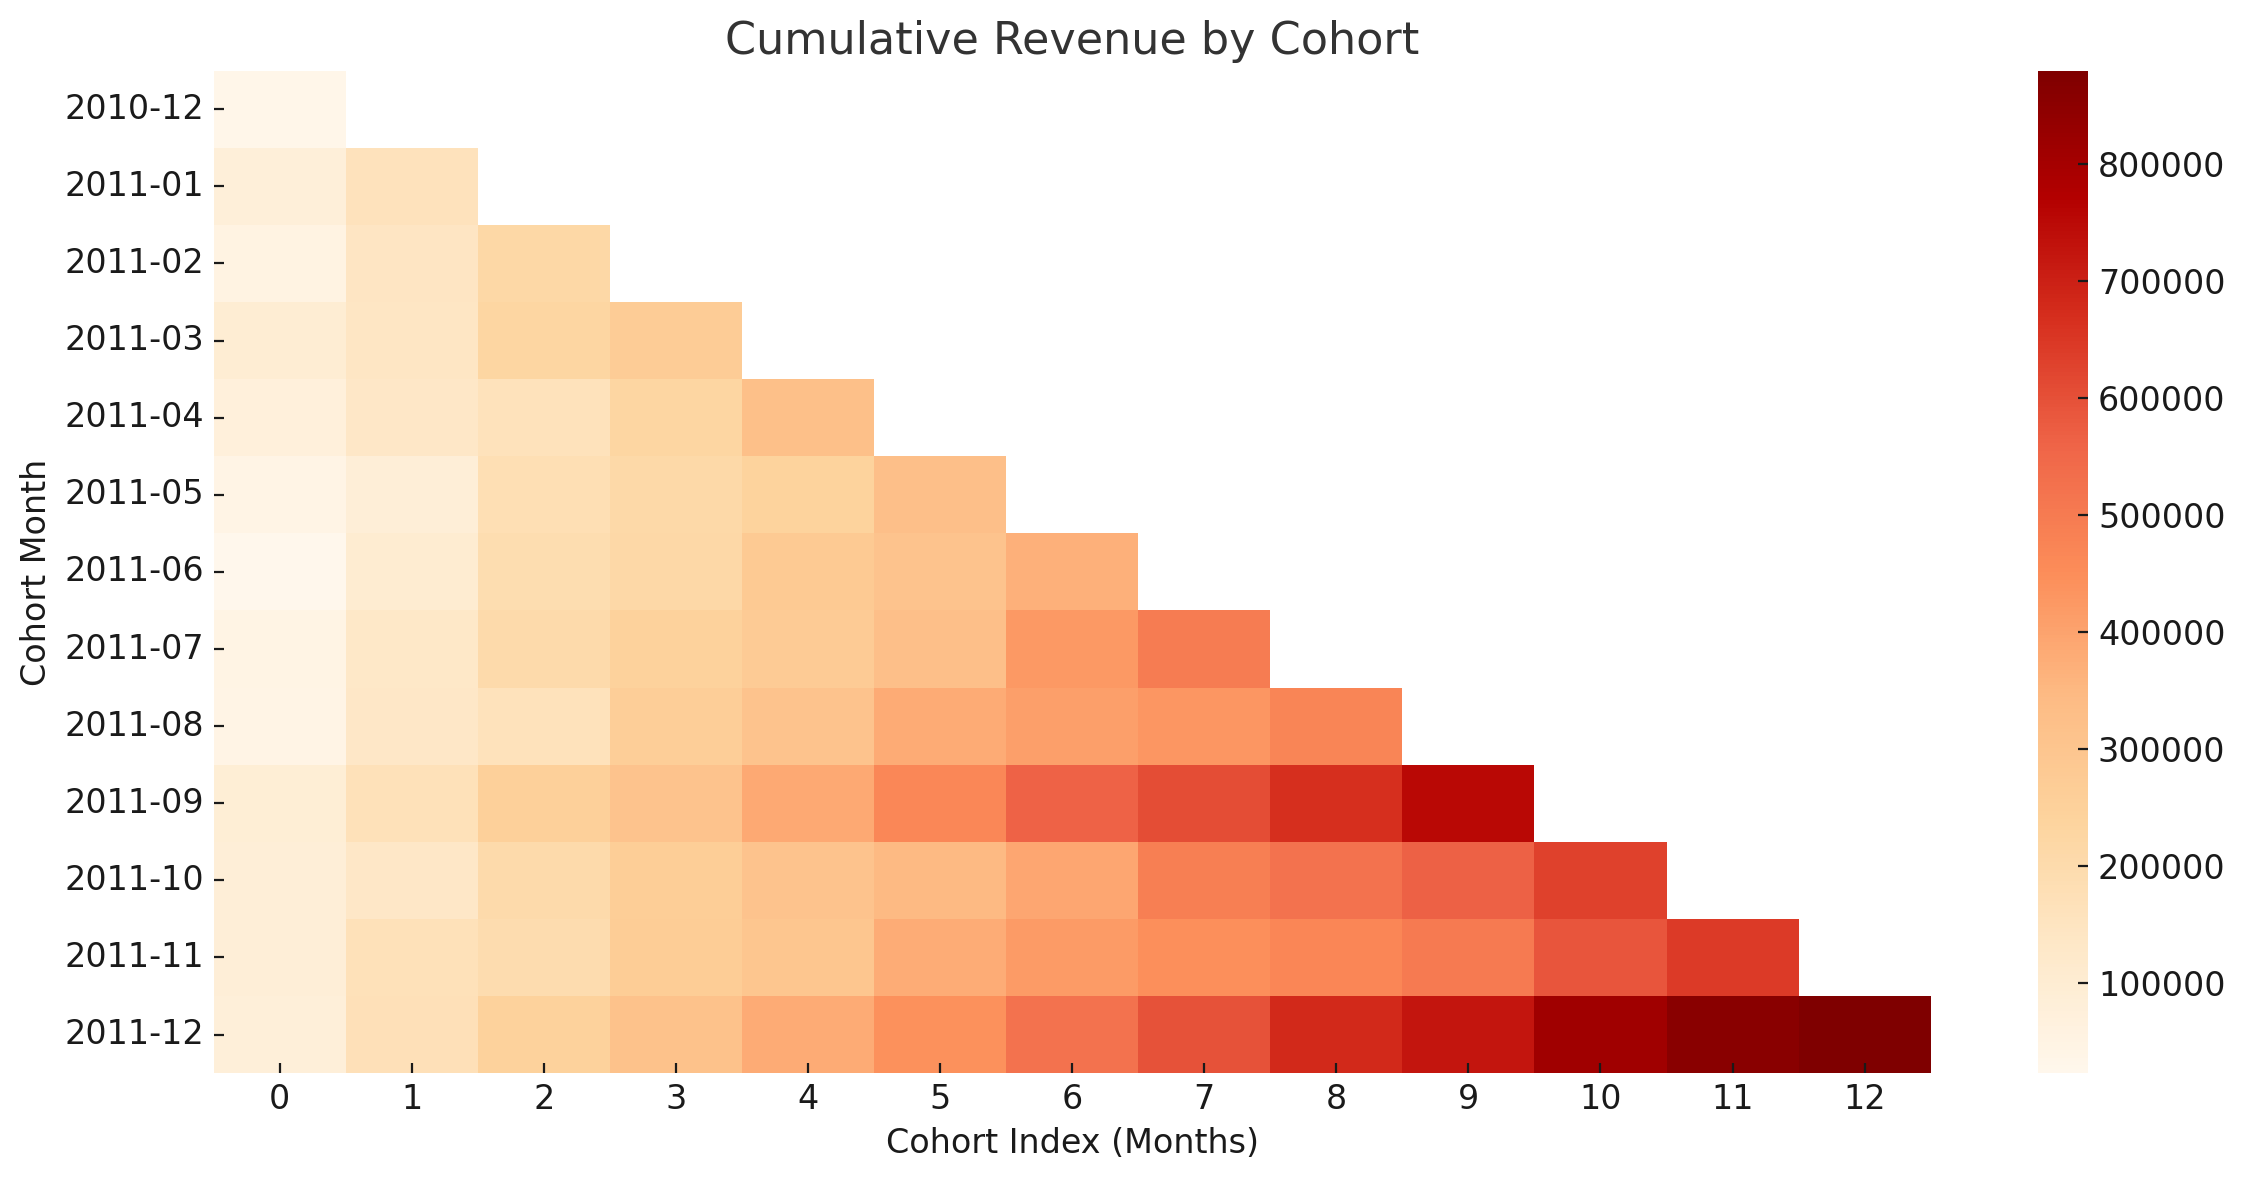

In [9]:
# Average Order Value (AOV)
orders = df.groupby(['CustomerID', 'InvoiceNo'])['TotalPrice'].sum().reset_index()
avg_order_value = orders['TotalPrice'].mean()
print("Average Order Value:", round(avg_order_value, 2))

Average Order Value: 476.09


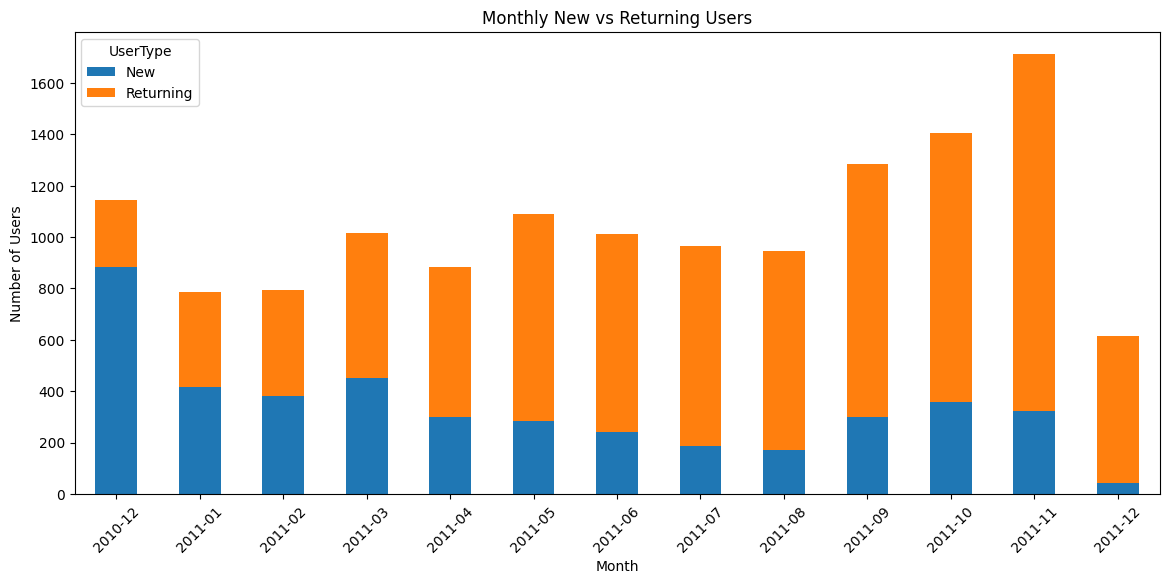

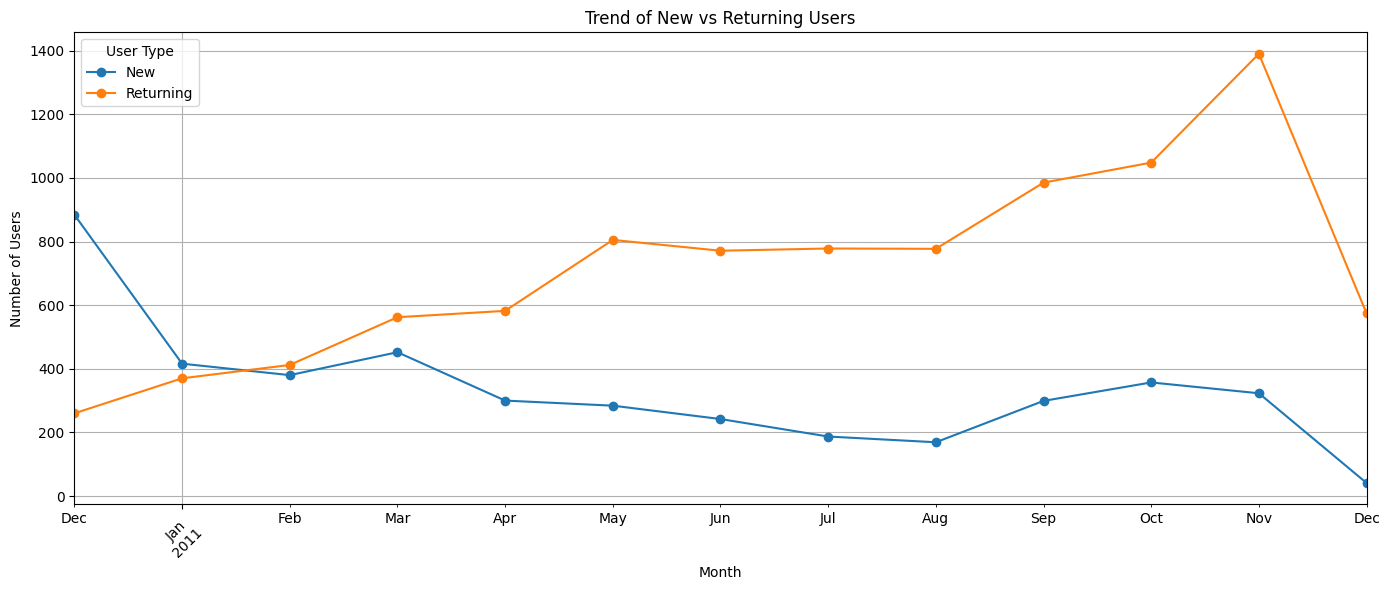

In [22]:
# New vs Returning users
df['FirstPurchaseDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')
df['UserType'] = np.where(df['InvoiceDate'] == df['FirstPurchaseDate'], 'New', 'Returning')

monthly_user_type = df.groupby([df['InvoiceDate'].dt.to_period('M'), 'UserType'])['CustomerID'].nunique().unstack()

monthly_user_type.plot(kind='bar', stacked=True, figsize=(14,6))
plt.title('Monthly New vs Returning Users')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)

monthly_user_type.plot(kind='line', figsize=(14,6), marker='o')

plt.title('Trend of New vs Returning Users')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.legend(title='User Type')
plt.grid(True)


plt.tight_layout()
plt.show()

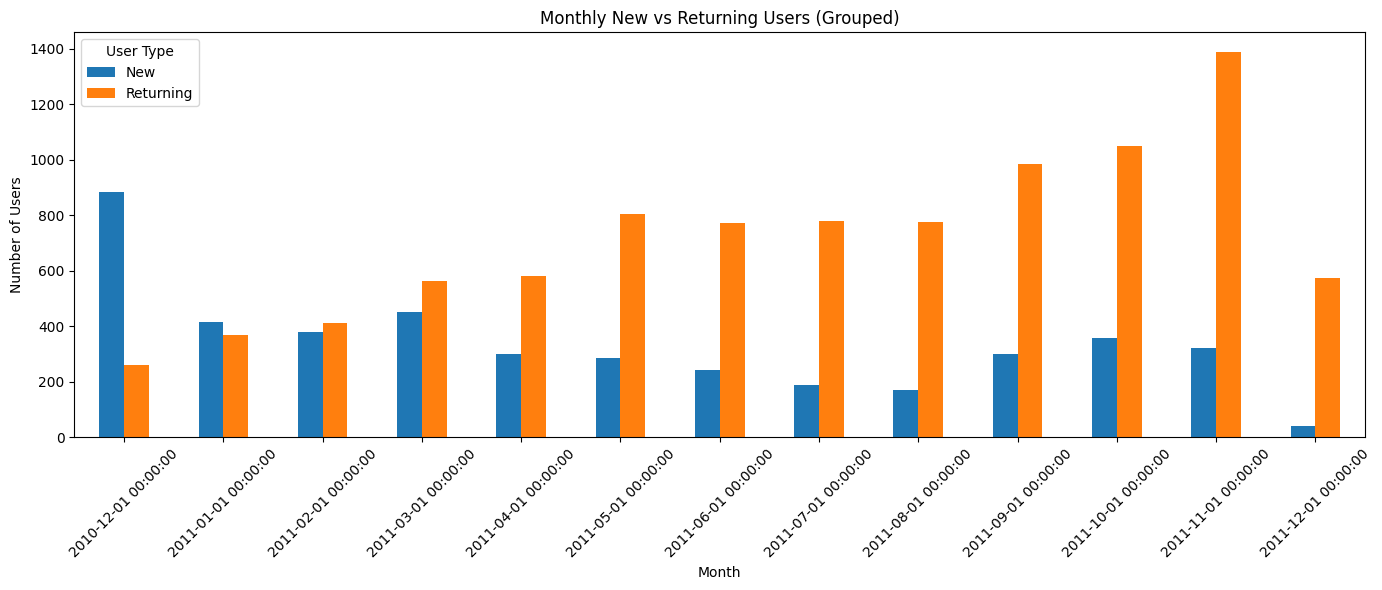

In [17]:
# Make sure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Mark new vs returning
df['FirstPurchaseDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')
df['UserType'] = np.where(df['InvoiceDate'] == df['FirstPurchaseDate'], 'New', 'Returning')

# Aggregate monthly user counts
monthly_user_type = (
    df.groupby([df['InvoiceDate'].dt.to_period('M'), 'UserType'])['CustomerID']
    .nunique()
    .unstack()
    .fillna(0)
)

# Plot side-by-side bars
monthly_user_type.index = monthly_user_type.index.to_timestamp()
monthly_user_type.plot(kind='bar', figsize=(14,6))

plt.title('Monthly New vs Returning Users (Grouped)')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.legend(title='User Type')
plt.tight_layout()
plt.show()


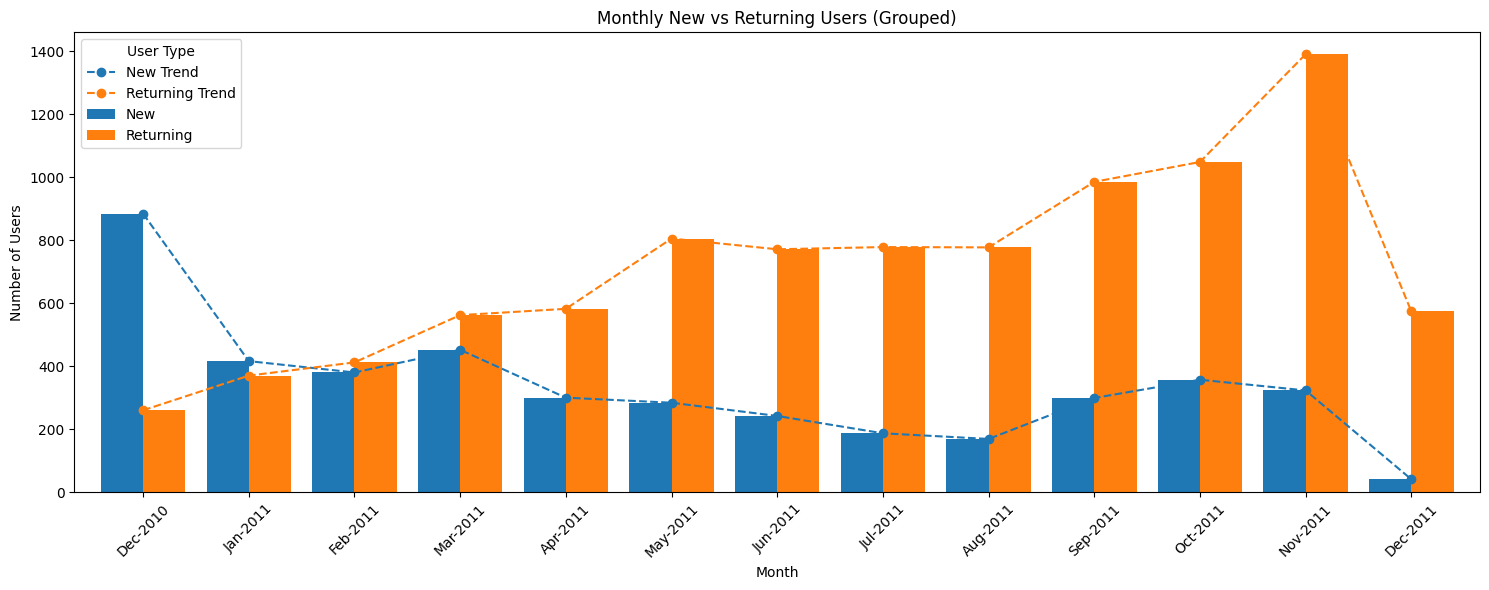

In [18]:
# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Classify users as New or Returning
df['FirstPurchaseDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')
df['UserType'] = np.where(df['InvoiceDate'] == df['FirstPurchaseDate'], 'New', 'Returning')

# Group by month and user type
monthly_user_type = (
    df.groupby([df['InvoiceDate'].dt.to_period('M'), 'UserType'])['CustomerID']
    .nunique()
    .unstack()
    .fillna(0)
)

# Convert period index to timestamp for plotting
monthly_user_type.index = monthly_user_type.index.to_timestamp()

# Plot grouped bars
ax = monthly_user_type.plot(kind='bar', figsize=(15,6), width=0.8)
plt.title('Monthly New vs Returning Users (Grouped)')
plt.xlabel('Month')
plt.ylabel('Number of Users')

# Format x-axis as month names
ax.set_xticks(np.arange(len(monthly_user_type)))
ax.set_xticklabels([d.strftime('%b-%Y') for d in monthly_user_type.index], rotation=45)

# Add trend lines on top
for user_type in monthly_user_type.columns:
    # Plot trend as line
    ax.plot(np.arange(len(monthly_user_type)), 
            monthly_user_type[user_type], 
            label=f'{user_type} Trend', 
            marker='o', linestyle='--')

# Adjust legend to avoid duplication
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), title="User Type")

plt.tight_layout()
plt.show()


This **stacked bar chart** titled **“Monthly New vs Returning Users”** shows the **composition of users** (by type) across different months. Let’s break down the interpretation step by step:

---

### 📊 **What’s Being Plotted?**

* **X-axis:**
  Months from **Dec 2010 to Dec 2011** (aggregated monthly).

* **Y-axis:**
  **Number of users** active in each month.

* **Bar Colors:**

  * 🟦 **Blue (New users):** Customers purchasing for the **first time** in that month.
  * 🟧 **Orange (Returning users):** Customers who have **purchased before**, but returned again in that month.

---

### 🧠 **How to Read This?**

Each bar is a stack of:

* **New Users (bottom part):** Fresh customer acquisition.
* **Returning Users (top part):** Customer retention.

So:

* The **total bar height** = **total unique users in that month**
* The **blue portion** = **acquisition**
* The **orange portion** = **retention**

---

### 📌 **Key Observations and Business Interpretation:**

#### ✅ **Customer Retention is Improving Over Time**

* From early 2011 to late 2011, the **orange portion consistently grows**.
* This means the business is doing a good job of bringing **existing customers back** to purchase again.

#### ⚠️ **New Customer Acquisition is Dropping**

* The **blue portion is highest in Dec 2010**, then **declines over time**.
* This suggests that **fewer new customers are joining each month** — marketing or awareness might need attention.

#### 🚀 **November 2011 Spike**

* A **peak in total user count** appears in **Nov 2011**, driven by a surge in returning users.
* Possibly a campaign, seasonal sale, or effective CRM triggered strong repeat purchases.

#### 📉 **December 2011 Drop**

* Sharp decline in total users (both new and returning) in Dec 2011.
* Could be due to **incomplete data**, **holidays**, or **end-of-year shutdown**.

---

### 💼 **Business Actionables:**

* 📣 **Boost Acquisition Campaigns:** Since new user growth is slowing, invest in ads, referral programs, or awareness.
* 🤝 **Double Down on Retention:** The high orange bars show loyal customers — offer loyalty perks or personalized deals.
* 🧐 **Investigate November Success:** Analyze what worked in Nov 2011 and replicate it.
* ⚠️ **Check December Data Quality:** Ensure no data issues (missing/incomplete) or explain with seasonality.

---

Let me know if you want a similar plot for *Revenue from New vs Returning Users*, or a notebook-ready code for this plot!


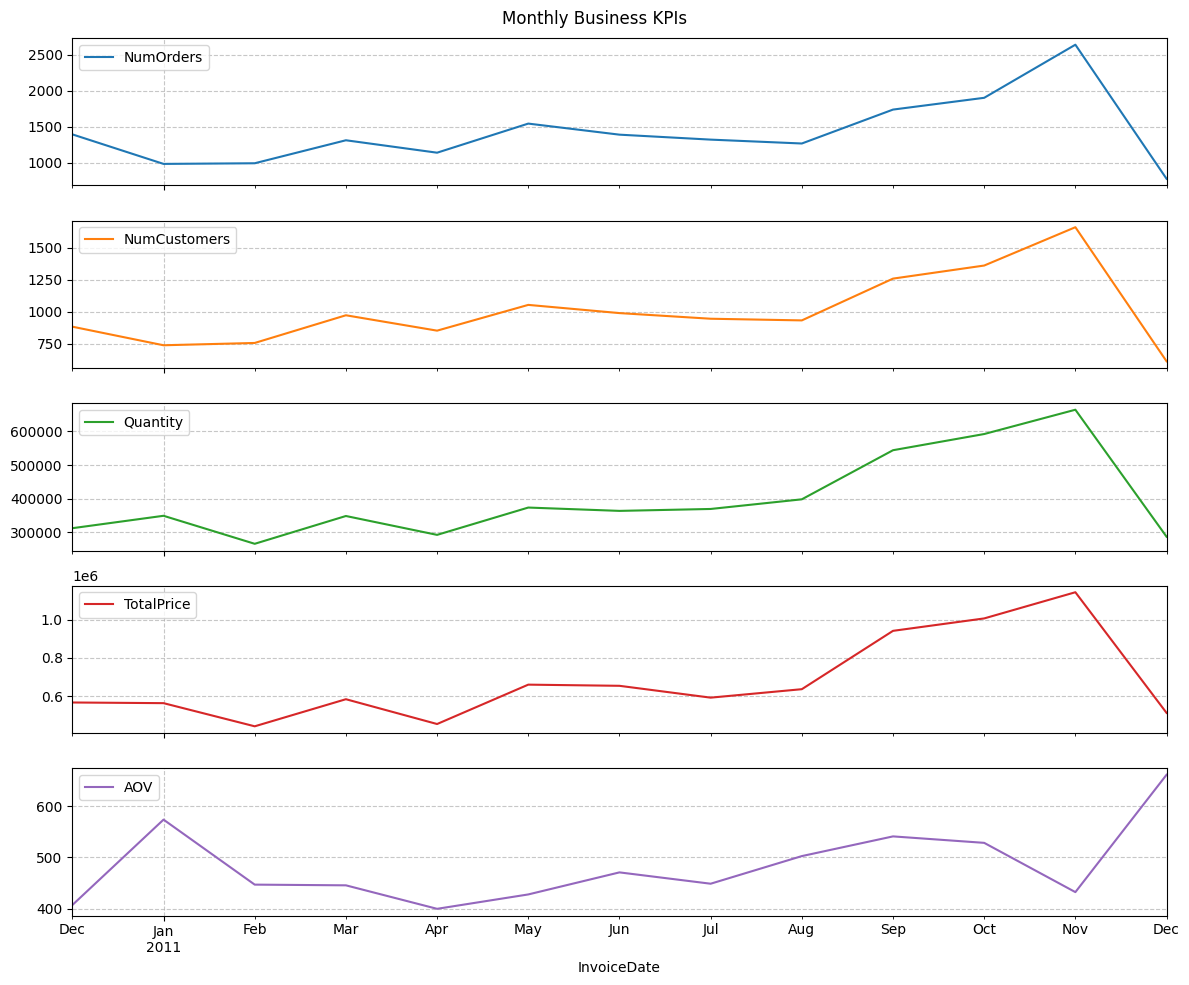

In [24]:
import matplotlib.pyplot as plt

# Resample and aggregate
monthly_metrics = df.set_index('InvoiceDate').resample('M').agg({
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceNo': 'NumOrders', 'CustomerID': 'NumCustomers'})

# Average Order Value (AOV)
monthly_metrics['AOV'] = monthly_metrics['TotalPrice'] / monthly_metrics['NumOrders']

# Plot with gridlines on each subplot
axes = monthly_metrics.plot(subplots=True, figsize=(12, 10), title='Monthly Business KPIs')

# Add grid to each subplot
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Here's how to **add gridlines** to each subplot in your existing `monthly_metrics.plot(subplots=True)` chart, and a **breakdown of the business insights** from your KPIs:

---

### ✅ Updated Code (with gridlines on all plots):

```python
import matplotlib.pyplot as plt

# Resample and aggregate
monthly_metrics = df.set_index('InvoiceDate').resample('M').agg({
    'InvoiceNo': 'nunique',
    'CustomerID': 'nunique',
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).rename(columns={'InvoiceNo': 'NumOrders', 'CustomerID': 'NumCustomers'})

# Average Order Value (AOV)
monthly_metrics['AOV'] = monthly_metrics['TotalPrice'] / monthly_metrics['NumOrders']

# Plot with gridlines on each subplot
axes = monthly_metrics.plot(subplots=True, figsize=(12, 10), title='Monthly Business KPIs')

# Add grid to each subplot
for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
```

---

### 📊 Business Insights from the KPIs:

#### 1. **NumOrders (Number of Orders)**:

* Fluctuates early in the year, then shows a **sharp increase toward October–November**.
* Suggests **seasonal or promotional spikes** in late Q4.

#### 2. **NumCustomers**:

* Gradual growth over the months, especially from August onwards.
* Indicates **increasing customer acquisition** or reactivation efforts paying off.

#### 3. **Quantity**:

* Spikes match the increase in orders and customers.
* Suggests **higher basket sizes** or **bulk buying** towards the end of the year.

#### 4. **TotalPrice (Revenue)**:

* Revenue peaks in November.
* Possibly a **Black Friday / holiday season boost**.

#### 5. **AOV (Average Order Value)**:

* Fluctuates, with a spike in **December and January**.
* Indicates **high-value orders** during those months — maybe **gifting or corporate purchases**.

---

Let me know if you'd like:

* % growth between months,
* Year-over-year comparison (YoY),
* Annotation of spikes (e.g., promo events),
* A dashboard layout version.


In [ ]:

















# Export CSVs for dashboarding
retention.to_csv("retention_matrix.csv")
cohort_pivot.to_csv("cohort_customers.csv")
revenue_pivot.to_csv("cohort_revenue.csv")
